In [2]:
from collections import OrderedDict
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image

from IPython.display import display

print(torch.__version__)


1.12.1


In [3]:
def try_gpu():
    if torch.cuda.device_count() > 0:
        return torch.device("cuda:0")

    return torch.device("cpu")

device = try_gpu()
device


device(type='cpu')

### Load data

In [4]:
# Read and process shakespeare

import string

import gensim.downloader
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

from nltk.corpus import stopwords
from nltk import word_tokenize


DATA_DIR = "data/shakespear.txt"


def load_preprocess_data():
    with open(DATA_DIR, "r") as f:
        data = [l.rstrip().lower() for l in f.readlines()]
    
    data = [line.translate(str.maketrans('', '', string.punctuation)) for line in data]
    data = [word_tokenize(line) for line in data]

    return data

def remove_stopwords(data, sw=stopwords.words("english")):
    res = []
    for line in data:
        original = line
        line = [w for w in line if w not in sw]
        if len(line) < 1:
            line = original
        res.append(line)
    return res

data = load_preprocess_data()
data_clean = remove_stopwords(data)

display(data[:2])
print("=" * 30)
display(data_clean[:2])




[['that',
  'poor',
  'contempt',
  'or',
  'claimd',
  'thou',
  'slept',
  'so',
  'faithful'],
 ['i',
  'may',
  'contrive',
  'our',
  'father',
  'and',
  'in',
  'their',
  'defeated',
  'queen']]

[['poor', 'contempt', 'claimd', 'thou', 'slept', 'faithful'],
 ['may', 'contrive', 'father', 'defeated', 'queen']]

In [5]:
# Determine vocab size
from collections import Counter


data_clean_flat = [word for line in data_clean for word in line]
vocab = Counter(data_clean_flat)
print(f"Vocab size: {len(vocab)}")

vocab_index = {k: i for i, k in enumerate(vocab)}
# Add special token for unknown words
vocab_index["<UNK>"] = len(vocab_index)


Vocab size: 3407


### Why self-attention?

In [6]:
B, T, C = 2, 8, 2
X = torch.randn(B, T, C)
X.shape


torch.Size([2, 8, 2])

In [9]:
# 1st idea - running avg
X_avg = torch.zeros((B, T, C))

for b in range(B):
    for t in range(T):
        X_avg[b, t] = torch.mean(X[b, :t + 1], 0)
        
print(X[0])
print()
print(X_avg[0])


tensor([[-0.9581,  0.9831],
        [-0.6718,  1.3933],
        [-0.5727, -0.0802],
        [-1.1377, -1.2894],
        [ 0.3739, -0.9770],
        [ 0.2736, -0.6151],
        [-0.8077, -0.1310],
        [ 0.5058,  0.3399]])

tensor([[-0.9581,  0.9831],
        [-0.8150,  1.1882],
        [-0.7342,  0.7654],
        [-0.8351,  0.2517],
        [-0.5933,  0.0060],
        [-0.4488, -0.0976],
        [-0.5001, -0.1023],
        [-0.3743, -0.0471]])


In [10]:
# The same, but with matrix multiplication
triag_ones = torch.tril(torch.ones(T, T))
print(triag_ones)

# Normalize to get an average
triag_ones = triag_ones / triag_ones.sum(1, keepdim=True)
print(triag_ones)

X_avg_matmul = triag_ones @ X  # Broadcasting!
print(X_avg_matmul[0])


tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
tensor([[-0.9581,  0.9831],
        [-0.8150,  1.1882],
        [-0.73

In [27]:
# The same, but with softmax
mask = torch.tril(torch.ones(T, T))
w = torch.zeros((T, T))
w = w.masked_fill(mask == 0, float("-inf"))
print(w)
w = F.softmax(w, dim=-1)
print(w)

X_avg_softmax = w @ X
print(X_avg_softmax[0])


tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
tensor([[-0.42

In [35]:
# We can compute not average, but smth more interesting
# We just switch from normalized ones to learnable weights

head_size = 16
queries = nn.Linear(C, head_size, bias=False)  # Where to look at
keys = nn.Linear(C, head_size, bias=False)  # What to give out

Q = queries(X)  # B, T, head_size
K = keys(X)  # B, T, head_size
W = Q @ K.transpose(-2, -1)  # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
print(W.shape)

W = W.masked_fill(mask == 0, float("-inf"))
W = F.softmax(W, dim=-1)
display(W[0])

out = W @ X
print(out.shape)


torch.Size([2, 8, 8])


tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4511, 0.5489, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5757, 0.1867, 0.2376, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3159, 0.1523, 0.0971, 0.4348, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0597, 0.2216, 0.3767, 0.0316, 0.3105, 0.0000, 0.0000, 0.0000],
        [0.1093, 0.2030, 0.1315, 0.0695, 0.3798, 0.1067, 0.0000, 0.0000],
        [0.0414, 0.1448, 0.2904, 0.0235, 0.1757, 0.0111, 0.3131, 0.0000],
        [0.1174, 0.0561, 0.0294, 0.1555, 0.0589, 0.3087, 0.0403, 0.2337]],
       grad_fn=<SelectBackward0>)

torch.Size([2, 8, 2])


In [36]:
# But why use raw X if we can use transformed/learned X
values = nn.Linear(C, head_size, bias=False)
V = values(X)

out = W @ V
print(out.shape)


torch.Size([2, 8, 16])


### Scale things - we don't want to have OHE as softmax

In [38]:
k_ = torch.randn(B, T, head_size)
q_ = torch.randn(B, T, head_size)
w_ = q_ @ k_.transpose(-2, -1)

print(k_.var())
print(q_.var())
print(w_.var())


tensor(1.0241)
tensor(0.9781)
tensor(16.9475)


In [42]:
print((w_ * head_size ** -0.5).var())


tensor(1.0592)


### Multi head attention - just stack scaled attention block

In [65]:
class ScaledAttention(nn.Module):
    def __init__(self, embed_size, head_size, block_size=256, dropout=0.2):
        super().__init__()
        self.head_size = head_size
        
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        
        self.mask = torch.tril(torch.ones(block_size, block_size, requires_grad=False))
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X):
        B, T, C = X.shape
        
        Q = self.query(X)
        K = self.key(X)
        V = self.value(X)
        
        out = Q @ K.transpose(-2, -1) * C ** -0.5
        out = out.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        out = F.softmax(out, dim=-1)
        
        out = self.dropout(out)
        out = out @ V
        
        return out


In [71]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embed_size, dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([ScaledAttention(embed_size, head_size) for _ in range(num_heads)])
        self.lin = nn.Linear(head_size * num_heads, embed_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X):
        out = torch.cat([head(X) for head in self.heads], dim=-1)
        out = self.dropout(out)
        
        return out


In [72]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, num_heads, dropout=0.2):
        super().__init__()
        head_size = embed_size // num_heads
        self.attention = MultiHeadAttention(num_heads, head_size, embed_size)
        self.ffn = nn.Sequential(
            OrderedDict([
                ("ff_lin_1", nn.Linear(embed_size, embed_size * 4)),  # Arbitrary
                ("ff_relu", nn.ReLU()),
                ("ff_lin_1", nn.Linear(embed_size * 4, embed_size)),
                ("ff_dropout", nn.Dropout(dropout)),
            ])
        )
        self.ln_1 = nn.LayerNorm(embed_size)
        self.ln_2 = nn.LayerNorm(embed_size)
        
    def forward(self, X):
        out = X + self.attention(self.ln_1(X))  # Residual connection
        out = X + self.attention(self.ln_1(out))
        
        return out


In [73]:
EMBED_SIZE = 384
NUM_HEADS = 4

tb = TransformerBlock(EMBED_SIZE, NUM_HEADS)
print(sum([p.nelement() for p in tb.parameters()]))
tb


1181952


TransformerBlock(
  (attention): MultiHeadAttention(
    (heads): ModuleList(
      (0): ScaledAttention(
        (query): Linear(in_features=384, out_features=96, bias=False)
        (key): Linear(in_features=384, out_features=96, bias=False)
        (value): Linear(in_features=384, out_features=96, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): ScaledAttention(
        (query): Linear(in_features=384, out_features=96, bias=False)
        (key): Linear(in_features=384, out_features=96, bias=False)
        (value): Linear(in_features=384, out_features=96, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): ScaledAttention(
        (query): Linear(in_features=384, out_features=96, bias=False)
        (key): Linear(in_features=384, out_features=96, bias=False)
        (value): Linear(in_features=384, out_features=96, bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (3): ScaledAttention(
        (query)

In [75]:
X_ = torch.randn((3, 16, EMBED_SIZE))
tb(X_).shape


torch.Size([3, 16, 384])

### Positional embeddings

$$\Large P(k, 2_i) = sin(\frac{pos}{n^{2_i/d}}) $$

$$\Large P(k, 2_i + 1) = cos(\frac{pos}{n^{2_{i + 1}/d}}) $$

In attention paper $n = 10$

In [29]:
def pos_encoding(seq_len, d, n=10000):
    emb = np.zeros((seq_len, d))

    for p in range(seq_len):
        for i in range(d // 2):
            den = np.power(n, 2 * i / d)
            emb[p, 2 * i] = np.sin(p / den)
            emb[p, 2 * i + 1] = np.cos(p / den)

    return emb
 
pos_emb = pos_encoding(seq_len=4, d=4, n=100)
print(pos_emb)


[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


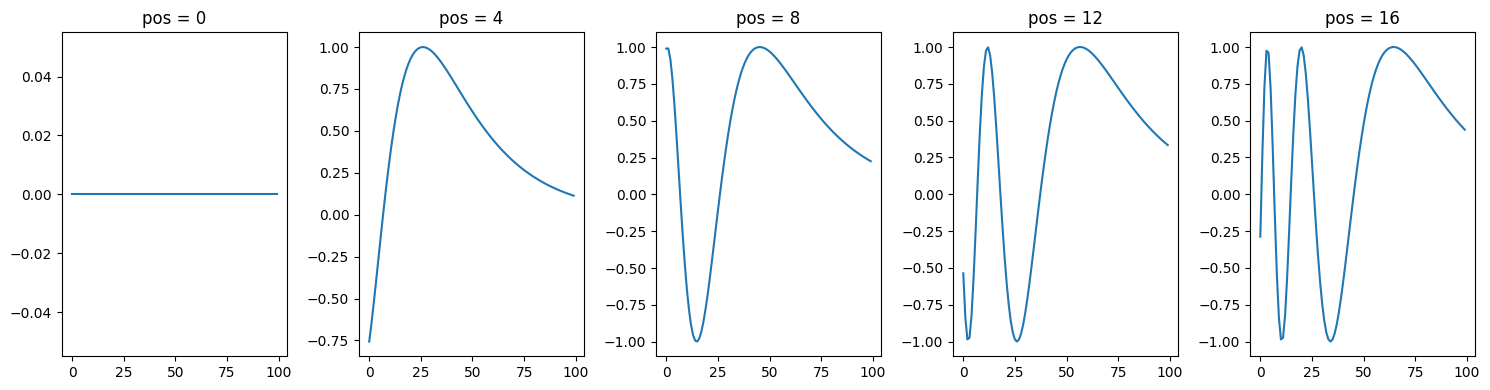

In [37]:
def plot_sin(pos, d=512, n=10000):
    x = np.arange(0, 100, 1)
    den = np.power(n, 2 * x / d)
    y = np.sin(pos / den)
    plt.plot(x, y)
    plt.title(f"pos = {pos}")
    

fig = plt.figure(figsize=(15, 4))    
for i in range(5):
    plt.subplot(151 + i)
    plot_sin(i * 4)
    plt.tight_layout()


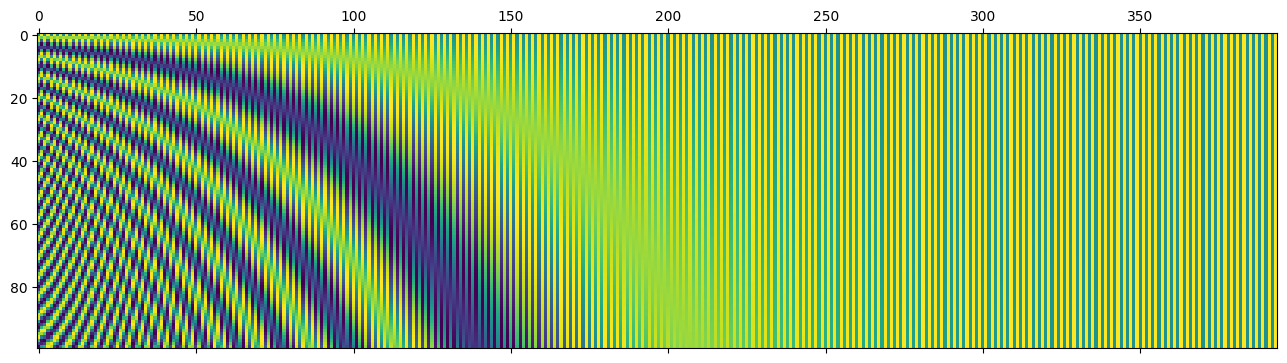

In [42]:
plt.matshow(pos_encoding(100, 394));
